### 1. Imports

In [1]:
import pandas as pd
import numpy as np

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [3]:
NUM_ROWS = 500
NUM_EPOCHS = 1000

### 2. Load data

In [4]:
df = pd.read_excel(
    '../../data/real/TLP_Identia.xlsx'
)

In [5]:
df.head()

,ISC.FPacientes.IDUsuario,ISC.FPacientes.etiquetaDiagnosticaExpTLP,ED_2Clases,ISC.FPacientes.etiquetaDiagnostica,ED_MMSE_2Clases,ISC.FPacientes.genero,ISC.FPacientes.Edad,ISC.resultadosCovid.numDosis,ISC.resultadosCovid.numVecesCovid,ISC.resultadosCovid.numVecesCovid_mode,ISC.resultadosCovid.pasadoCovid,ISC.resultadosCovid.sentimientoAislado,ISC.resultadosCovid.sentimientoAislado_mediaFiltro,ISC.resultadosCovid.sentimientoAislado_mode,ISC.resultadosCovid.sintomaCansancio,ISC.resultadosCovid.sintomaDiarrea,ISC.resultadosCovid.sintomaDifRespirar,ISC.resultadosCovid.sintomaDolCabeza,ISC.resultadosCovid.sintomaDolGarganta,ISC.resultadosCovid.sintomaDolMuscular,ISC.resultadosCovid.sintomaEscalofrios,ISC.resultadosCovid.sintomaFiebre,ISC.resultadosCovid.sintomaOtro,ISC.resultadosCovid.sintomaOtroString,ISC.resultadosCovid.sintomaPerGusto,ISC.resultadosCovid.sintomaPerOlfato,ISC.resultadosCovid.vacunado,ISC.resultadosCribaje.Total.PD,ISC.resultadosObservacion.alcohol,ISC.resultadosObservacion.ansiedad,ISC.resultadosObservacion.añosSinFumar,ISC.resultadosObservacion.añosSinFumar_Rangos,ISC.resultadosObservacion.consumoAlcohol_UBEsemanal,ISC.resultadosObservacion.consumoAlcohol_UBEsemanal_knn,ISC.resultadosObservacion.consumoAlcohol_UBEsemanal_mode&rangoEdad,ISC.resultadosObservacion.depresion,ISC.resultadosObservacion.enfermedadesAltTiroides,ISC.resultadosObservacion.enfermedadesAntecedentesCardiacos,ISC.resultadosObservacion.enfermedadesCardiopatiaIsquemica,ISC.resultadosObservacion.enfermedadesDiabetes,ISC.resultadosObservacion.enfermedadesHepatica,ISC.resultadosObservacion.enfermedadesHipercolesterolemia,ISC.resultadosObservacion.enfermedadesHipertension,ISC.resultadosObservacion.enfermedadesNinguna,ISC.resultadosObservacion.enfermedadesOtros,ISC.resultadosObservacion.enfermedadesRenal,ISC.resultadosObservacion.entorno,ISC.resultadosObservacion.familiaresAlzheimer,ISC.resultadosObservacion.familiaresOtraDemencia,ISC.resultadosObservacion.fumador,ISC.resultadosObservacion.numCigarros,ISC.resultadosObservacion.numCigarrosDia_knn,ISC.resultadosObservacion.numCigarrosDia_mode&rangoEdad,ISC.resultadosObservacion.tratCronico,ISC.resultadosObservacion.tratPsicologic,ISC.resultadosObservacion.tratPsiquiatrico,ISC.resultadosOtros.frecOlvidos,ISC.resultadosOtros.frecUsoEmail,ISC.resultadosOtros.frecUsoMovil,ISC.resultadosOtros.frecUsoOrdenador,ISC.resultadosOtros.frecUsoRSociales,ISC.resultadosOtros.frecUsoTele,ISC.resultadosOtros.nivelActFisica,ISC.resultadosOtros.nivelSociabilidad,ISC.resultadosReservaCognitiva.Total.PD,ISC.resultadosReservaCognitiva.actividadLectora,ISC.resultadosReservaCognitiva.cursos,ISC.resultadosReservaCognitiva.escolaridad,ISC.resultadosReservaCognitiva.escolaridadPadres,ISC.resultadosReservaCognitiva.formacionMusical,ISC.resultadosReservaCognitiva.idiomas,ISC.resultadosReservaCognitiva.juegos,ISC.resultadosReservaCognitiva.ocupacion,ISC.resultadosWFQ.DE_array,ISC.resultadosWFQ.DE_total.PD,ISC.resultadosWFQ.NO_array,ISC.resultadosWFQ.NO_total.PD,ISC.resultadosWFQ.SA_array,ISC.resultadosWFQ.SA_total.PD,TLP.CubCorsi.Directos.PD,TLP.CubCorsi.Directos.PDC,TLP.CubCorsi.Directos.PZ,TLP.CubCorsi.Inversos.PD,TLP.CubCorsi.Inversos.PDC,TLP.CubCorsi.Inversos.PZ,TLP.CubCorsi.Total.PD,TLP.CubCorsi.Total.PDC,TLP.CubCorsi.Total.PZ,TLP.FigRey.Copia.PD,TLP.FigRey.Copia.PDC,TLP.FigRey.Copia.PZ,TLP.FigRey.Duracion.PD,TLP.FigRey.Duracion.PDC,TLP.FigRey.Duracion.PZ,TLP.FigRey.Memoria.PD,TLP.FigRey.Memoria.PDC,TLP.FigRey.Memoria.PZ,TLP.FigRey.tipoCopia.PD,TLP.MMSE.Concentracion.PD,TLP.MMSE.Escolaridad.PD,TLP.MMSE.Fijacion.PD,TLP.MMSE.Lenguaje.PD,TLP.MMSE.Memoria.PD,TLP.MMSE.Orientacion.PD,TLP.MMSE.Total.PD,TLP.MMSE.Total.PDC,TLP.Stroop.color.PD,TLP.Stroop.color.PDC,TLP.Stroop.color.PT,TLP.Stroop.color.PZ,TLP.Stroop.interferencia.PD,TLP.Stroop.interferencia.PT,TLP.Stroop.interferencia.PZ,TLP.Stroop.palabras.PD,TLP.Stroop.palabras.PDC,TLP.Stroop.palabras.PT,TLP.Stroop.palabras.PZ,TLP.Stroop.palabrasColor.PD,TLP.Stroop.palabrasColor.PDC,TLP

In [6]:
df.replace([np.inf, -np.inf], 0, inplace=True)

### 3. Preprocesing

In [7]:
drop_columns = [
    'ISC.FPacientes.etiquetaDiagnostica',
    'ISC.FPacientes.IDUsuario',
    'ISC.FPacientes.etiquetaDiagnosticaExpTLP',
    'ED_MMSE_2Clases',
    'ISC.resultadosWFQ.DE_array',
    'ISC.resultadosWFQ.NO_array',
    'ISC.resultadosWFQ.SA_array'
]

In [8]:
df.drop(columns=drop_columns, inplace=True)

In [9]:
categorical_columns = [
    'ED_2Clases',
    'ISC.resultadosCovid.sintomaOtroString'
]

In [10]:
df[categorical_columns] = df[categorical_columns].astype('object')

In [11]:
df.dtypes

ED_2Clases                                                             object
ISC.FPacientes.genero                                                   int64
ISC.FPacientes.Edad                                                     int64
ISC.resultadosCovid.numDosis                                            int64
ISC.resultadosCovid.numVecesCovid                                     float64
ISC.resultadosCovid.numVecesCovid_mode                                  int64
ISC.resultadosCovid.pasadoCovid                                         int64
ISC.resultadosCovid.sentimientoAislado                                float64
ISC.resultadosCovid.sentimientoAislado_mediaFiltro                      int64
ISC.resultadosCovid.sentimientoAislado_mode                             int64
ISC.resultadosCovid.sintomaCansancio                                    int64
ISC.resultadosCovid.sintomaDiarrea                                      int64
ISC.resultadosCovid.sintomaDifRespirar                          

In [12]:
from sdv.metadata import Metadata

metadata = Metadata.detect_from_dataframe(data=df, table_name='TLP')

Auto detected data:



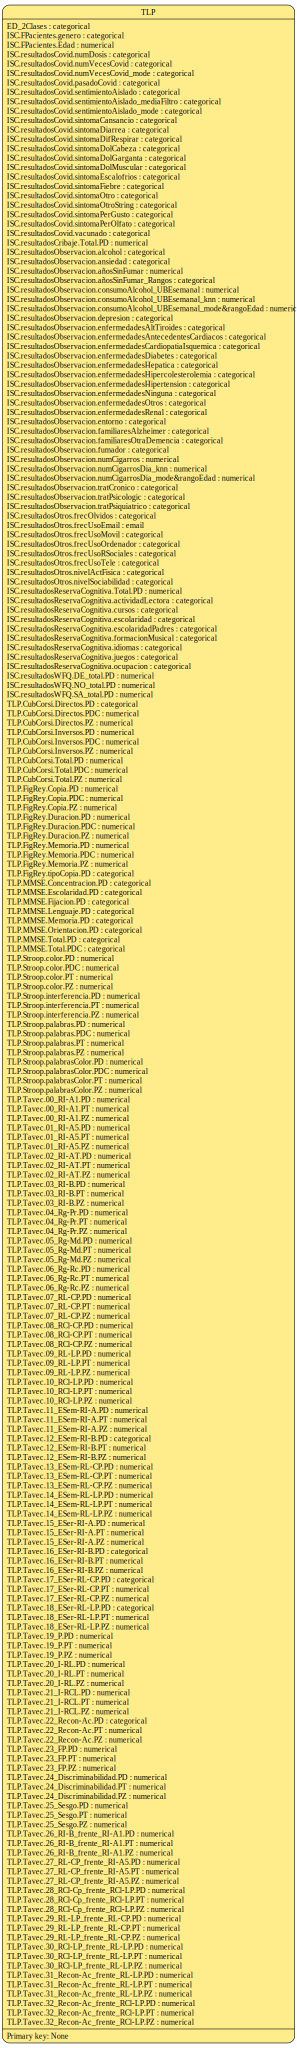

In [13]:
print('Auto detected data:\n')
metadata.visualize()

In [14]:
metadata.update_column(
    column_name='ISC.resultadosOtros.frecUsoEmail',
    sdtype='categorical'
    )

In [15]:
metadata.validate()

In [16]:
metadata.validate_table(data=df, table_name='TLP')

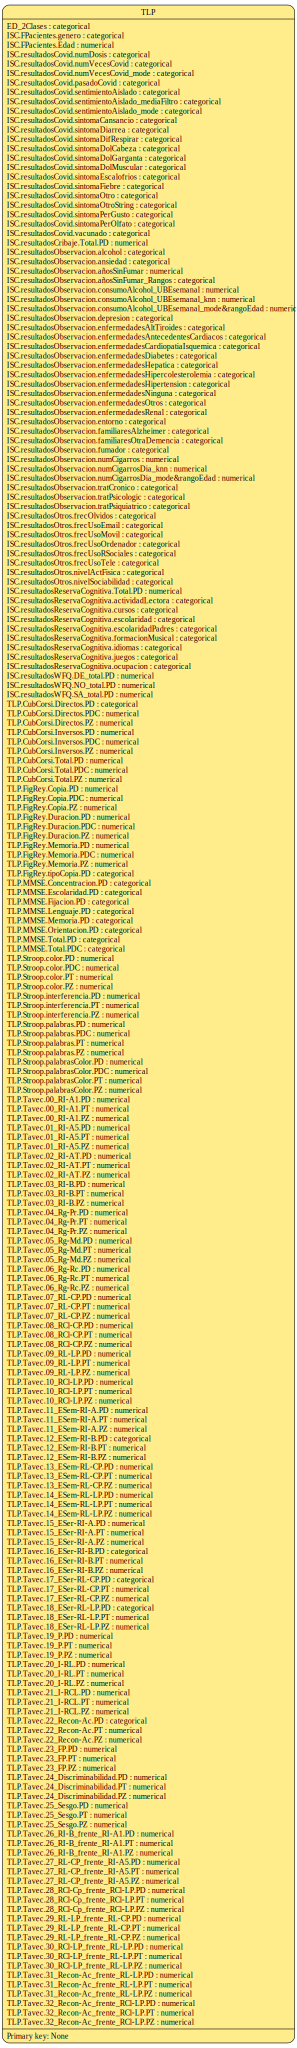

In [17]:
metadata.visualize()

In [18]:
import os
if os.path.exists("metadata.json"):
  os.remove("metadata.json")

metadata.save_to_json('metadata.json')

### 4. Synthesizers

#### 4.1. GaussianCopulaSynthesizer

In [19]:
from sdv.single_table import GaussianCopulaSynthesizer

gc_synthesizer = GaussianCopulaSynthesizer(
    metadata,
    enforce_min_max_values=False,
    enforce_rounding=True,
    locales=["es_ES"],
    numerical_distributions={},
    default_distribution='beta'
)

In [20]:
gc_synthesizer.auto_assign_transformers(df)

In [21]:
processed_df = gc_synthesizer.preprocess(df)

In [22]:
gc_synthesizer.fit_processed_data(processed_df)

In [23]:
df['ED_2Clases'].value_counts()

ED_2Clases
D    235
H     74
Name: count, dtype: int64

In [24]:
from sdv.sampling import Condition

class_d = Condition(
    num_rows=250,
    column_values={'ED_2Clases': 'D'}
)

class_h = Condition(
    num_rows=250,
    column_values={'ED_2Clases': 'H'}
)

In [38]:
gc_synthetic_data = gc_synthesizer.sample_from_conditions(
    conditions=[class_d, class_h],
    output_file_path='../../data/tlp/conditional-gc.csv'
)

Sampling conditions: 100%|██████████| 500/500 [00:01<00:00, 339.77it/s]


#### 4.2.CTGANSynthesizer

In [26]:
from sdv.single_table import CTGANSynthesizer

ctgan_synthesizer = CTGANSynthesizer(
    metadata,
    enforce_min_max_values=False,
    enforce_rounding=True,
    locales=['es_ES'],
    epochs=NUM_EPOCHS,
    verbose=True,
    cuda=True
)

In [27]:
ctgan_synthesizer.auto_assign_transformers(df)

In [28]:
processed_df = ctgan_synthesizer.preprocess(df)

PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name                                               Est # of Columns (CTGAN)
ED_2Clases                                                         2
ISC.FPacientes.genero                                              2
ISC.FPacientes.Edad                                                11
ISC.resultadosCovid.numDosis                                       6
ISC.resultadosCovid.numVecesCovid                                  5
ISC.resultadosCovid.numVecesCovid_mode                             4
ISC.resultadosCovid.pasadoCovid                                    2
ISC.resultadosCovid.sentimientoAislado                             6
ISC.resultadosCovid.sentimientoAislado_mediaFiltro                 5
ISC.resultadosCovid.sentimientoAislado_mode                        5
ISC.resultadosCovid.sintomaCansancio                               2
IS

In [29]:
ctgan_synthesizer.fit_processed_data(processed_df)

Gen. (-7.91) | Discrim. (0.46): 100%|██████████| 1000/1000 [21:24<00:00,  1.28s/it]


In [39]:
ctgan_synthetic_data = ctgan_synthesizer.sample_from_conditions(
    conditions=[class_d, class_h],
    output_file_path='../../data/tlp/conditional-ctgan.csv'
)

Sampling conditions:  98%|█████████▊| 492/500 [00:04<00:00, 107.70it/s]c:\Users\jgala\Documents\uned\tfm\synthetic-data\.venv\lib\site-packages\sdv\single_table\base.py:915: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sampled_rows[COND_IDX] = dataframe[COND_IDX].to_numpy()[: len(sampled_rows)]
Sampling conditions: 100%|██████████| 500/500 [00:05<00:00, 86.05it/s] 


#### 4.3. TVAESynthesizer

In [31]:
from sdv.single_table import TVAESynthesizer

tvaes_synthesizer = TVAESynthesizer(
    metadata,
    enforce_min_max_values=False,
    enforce_rounding=True,
    epochs=NUM_EPOCHS,
    verbose=True,
    cuda=True
)

In [32]:
tvaes_synthesizer.auto_assign_transformers(df)

In [33]:
processed_df = tvaes_synthesizer.preprocess(df)

In [34]:
tvaes_synthesizer.fit_processed_data(processed_df)

Loss: -288.250: 100%|██████████| 1000/1000 [07:51<00:00,  2.12it/s]


In [40]:
tvaes_synthetic_data = tvaes_synthesizer.sample_from_conditions(
    conditions=[class_d, class_h],
    output_file_path='../../data/tlp/conditional-tvaes.csv'
)

Sampling conditions:  50%|█████     | 250/500 [00:01<00:01, 173.83it/s]c:\Users\jgala\Documents\uned\tfm\synthetic-data\.venv\lib\site-packages\sdv\single_table\base.py:915: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sampled_rows[COND_IDX] = dataframe[COND_IDX].to_numpy()[: len(sampled_rows)]
Sampling conditions: 100%|█████████▉| 498/500 [00:03<00:00, 148.42it/s]c:\Users\jgala\Documents\uned\tfm\synthetic-data\.venv\lib\site-packages\sdv\single_table\base.py:915: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sampled_rows[COND

### 5. Evaluating Real vs. Synthetic Data

#### 5.1. GaussianCopulaSynthesizer

In [41]:
from sdv.evaluation.single_table import run_diagnostic

gc_diagnostic = run_diagnostic(
    real_data=df,
    synthetic_data=gc_synthetic_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 213/213 [00:00<00:00, 3511.92it/s]|
Data Validity Score: 96.52%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 97.12it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 98.26%



In [42]:
from sdv.evaluation.single_table import evaluate_quality

gc_quality_report = evaluate_quality(
    df,
    gc_synthetic_data,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 213/213 [00:00<00:00, 1757.19it/s]|
Column Shapes Score: 83.13%

(2/2) Evaluating Column Pair Trends: |██████████| 22578/22578 [01:08<00:00, 331.80it/s]|
Column Pair Trends Score: 80.92%

Overall Score (Average): 82.02%



In [50]:
# gc_details = gc_quality_report.get_details('Column Pair Trends')
# gc_details[gc_details['Real Correlation'].notnull()]

In [51]:
#gc_quality_report.get_details('Column Shapes')

In [52]:
# from sdv.evaluation.single_table import get_column_plot

# plot_columns = list(df.columns)
# for column in plot_columns:
#     fig = get_column_plot(
#         real_data=df,
#         synthetic_data=gc_synthetic_data,
#         column_name=column,
#         metadata=metadata
#     )
#     fig.show()

#### 5.2. CTGANSynthesizer

In [43]:
ctgan_diagnostic = run_diagnostic(
    real_data=df,
    synthetic_data=ctgan_synthetic_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 213/213 [00:00<00:00, 3657.81it/s]|
Data Validity Score: 95.17%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 251.79it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 97.58%



In [44]:
ctgan_quality_report = evaluate_quality(
    df,
    ctgan_synthetic_data,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 213/213 [00:00<00:00, 1215.91it/s]|
Column Shapes Score: 81.21%

(2/2) Evaluating Column Pair Trends: |██████████| 22578/22578 [01:10<00:00, 319.73it/s]|
Column Pair Trends Score: 76.16%

Overall Score (Average): 78.69%



In [55]:
# ctgan_details = ctgan_quality_report.get_details('Column Pair Trends')
# ctgan_details[ctgan_details['Real Correlation'].notnull()]

In [56]:
# ctgan_quality_report.get_details('Column Shapes')

In [57]:
# for column in plot_columns:
#     fig = get_column_plot(
#         real_data=df,
#         synthetic_data=ctgan_synthetic_data,
#         column_name=column,
#         metadata=metadata
#     )
#     fig.show()

#### 5.3. TVAESSynthesizer

In [45]:
tvaes_diagnostic = run_diagnostic(
    real_data=df,
    synthetic_data=tvaes_synthetic_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 213/213 [00:00<00:00, 3629.26it/s]|
Data Validity Score: 99.03%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 162.97it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 99.52%



In [46]:
tvaes_quality_report = evaluate_quality(
    df,
    tvaes_synthetic_data,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 213/213 [00:00<00:00, 1413.40it/s]|
Column Shapes Score: 87.61%

(2/2) Evaluating Column Pair Trends: |██████████| 22578/22578 [01:10<00:00, 320.64it/s]|
Column Pair Trends Score: 79.11%

Overall Score (Average): 83.36%



In [60]:
# tvaes_details = tvaes_quality_report.get_details('Column Pair Trends')
# tvaes_details[tvaes_details['Real Correlation'].notnull()]

In [61]:
# tvaes_quality_report.get_details('Column Shapes')

In [62]:
# for column in plot_columns:
#     fig = get_column_plot(
#         real_data=df,
#         synthetic_data=tvaes_synthetic_data,
#         column_name=column,
#         metadata=metadata
#     )
#     fig.show()